In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


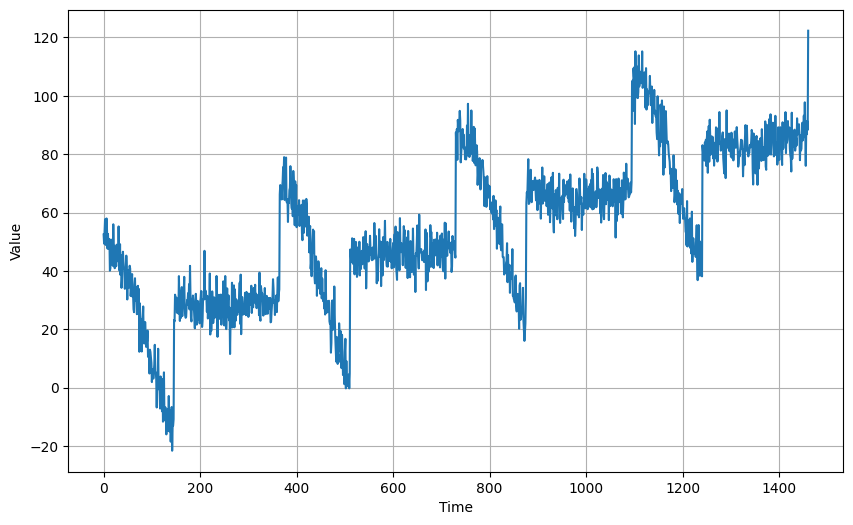

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


In [4]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [5]:

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [8]:
# Linear Model
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)


Epoch 1/100
31/31 [==============================] - 3s 47ms/step - loss: 14.5958 - mae: 15.0857 - val_loss: 16.2789 - val_mae: 16.7744
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 12.0446 - mae: 12.5313 - val_loss: 11.4280 - val_mae: 11.9156
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 11.1342 - mae: 11.6225 - val_loss: 10.1290 - val_mae: 10.6201
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 10.5938 - mae: 11.0825 - val_loss: 10.0941 - val_mae: 10.5846
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 10.0491 - mae: 10.5371 - val_loss: 9.2882 - val_mae: 9.7766
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 9.6057 - mae: 10.0919 - val_loss: 9.0850 - val_mae: 9.5696
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 9.1532 - mae: 9.6395 - val_loss: 8.6666 - val_mae: 9.1482
Epoch 8/100
31/31 [==============================] - 0s 8m

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


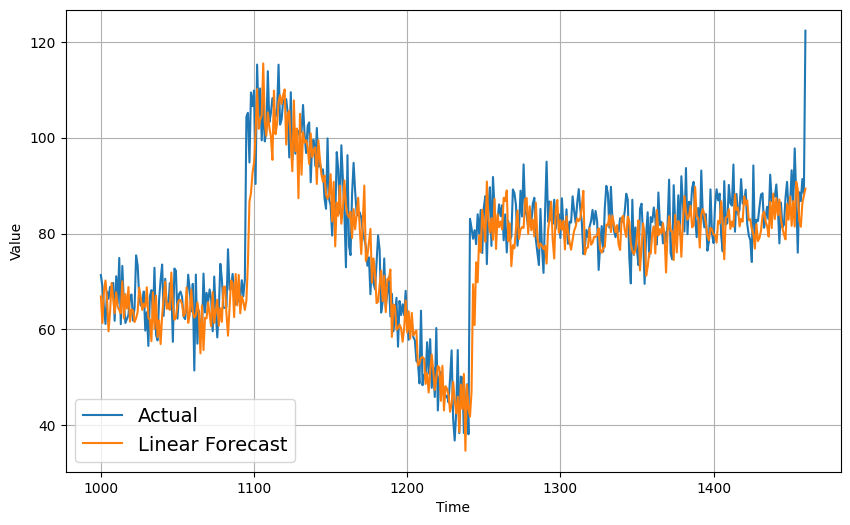

MAE for Linear Forecast: 5.67177


In [10]:

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Actual")
plot_series(time_valid, lin_forecast, label="Linear Forecast")
plt.show()

print("MAE for Linear Forecast:", keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy())


In [11]:
# Dense Model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])


lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 43.0703 - mae: 43.5700 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 43.0119 - mae: 43.5116 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 42.9402 - mae: 43.4399 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 42.8600 - mae: 43.3597 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 42.7703 - mae: 43.2699 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 42.6691 - mae: 43.1687 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 42.5550 - mae: 43.0546 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 42.4259 - mae: 42.9255 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 42.2806 - mae: 42.7802 

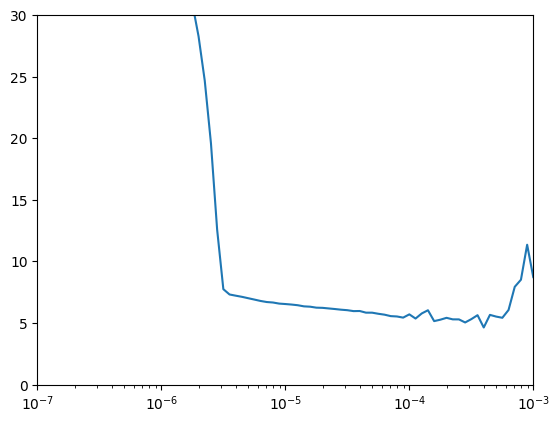

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-3, 0, 30])
plt.show()


In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 15.3661 - mae: 15.8593 - val_loss: 8.1714 - val_mae: 8.6621
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 9.0974 - mae: 9.5852 - val_loss: 8.1223 - val_mae: 8.6095
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 8.7371 - mae: 9.2250 - val_loss: 8.0828 - val_mae: 8.5710
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 8.5231 - mae: 9.0093 - val_loss: 8.4550 - val_mae: 8.9449
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 8.3601 - mae: 8.8446 - val_loss: 8.5317 - val_mae: 9.0214
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 8.2104 - mae: 8.6936 - val_loss: 7.4263 - val_mae: 7.9146
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 8.1596 - mae: 8.6478 - val_loss: 7.6301 - val_mae: 8.1162
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 7.9157 

15/15 [==============================] - 0s 6ms/step


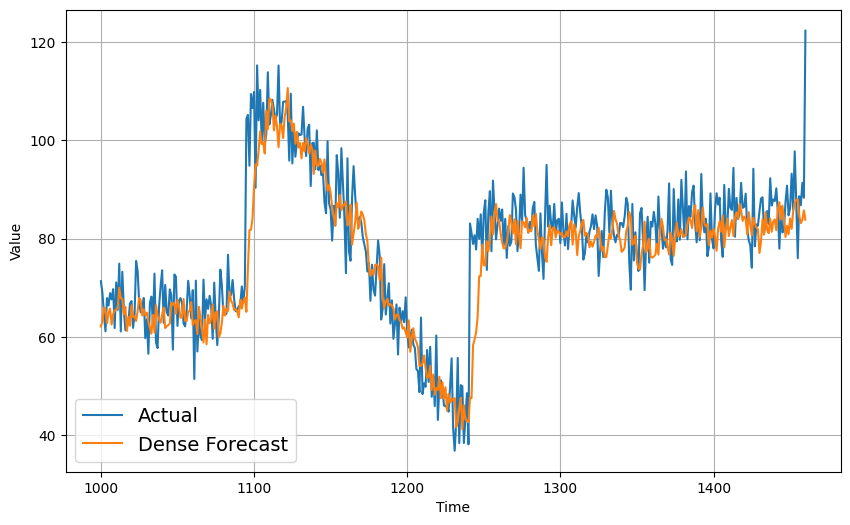

MAE for Dense Forecast: 5.3824644


In [14]:
dense_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Actual")
plot_series(time_valid, dense_forecast, label="Dense Forecast")
plt.show()

print("MAE for Dense Forecast:", keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy())